The algorithm is as follows:
1. crop the image so that only the tennis ball is visible.
2. use opencv so that the perimeter of the ball can be determined
3. Use that to find surface area as well as volume

Images for this analysis are manually extracted frames from https://youtu.be/1yT0hxplVBg.

In [1]:
import cv2 as cv2
import numpy as np

In [2]:
from skimage import io

The window [200:900,500:1500,0] changes with the image. Right now, it is decided manually.

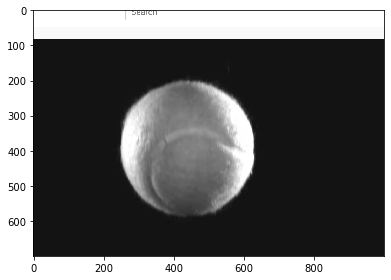

In [131]:
tennisBall = io.imread('TennisBallUndeformed.png')
io.imshow(tennisBall[200:900,500:1500,0]) 
tennisBallImage = tennisBall[200:900,500:1500,0]
#tennisBall = io.imread('TennisBallDeformed02.png')
#tennisBall = io.imread('TennisBallDeformed04.png')
#io.imshow(tennisBall[700:1400,500:1500,0])
#tennisBallImage = tennisBall[700:1400,500:1500,0]

# image of "deformed 04"

**Creating a threshold from the image**. Some manual work done here to get a reasonable bounding box around the image. the 700:1400 and 500:1500 is specific to 'TennisBallDeformed04.png'. 

I think the function is to be interpreted as follows: if the pixel value is greater than the thresh (65), make it maxval (255 or white); if it is less than thresh, make it 0 (black) since we are using binary thresholding.

ret is simply the value of the threshold value, 65 in this case. thresh (on the LHS is the thresholded image).

For different images, I have had to use different values of the threshold. For example, 25 for the undeformed ball.

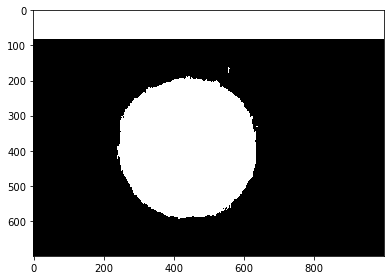

In [154]:
#ret,thresh = cv2.threshold(tennisBall[300:1000,500:1500,0],55,255,0)
ret,thresh = cv2.threshold(tennisBallImage,
                           thresh = 25,
                           maxval = 255,
                           type = cv2.THRESH_BINARY)

#ret,thresh = cv2.threshold(tennisBall,55,255,0)
io.imshow(thresh)

**Identify the contours:** I do not understand the details of the function well enough. It draws contours on the thresholded image.

In [156]:
contours, hierarchy = cv2.findContours(thresh, 
                                           cv2.RETR_TREE, 
                                           cv2.CHAIN_APPROX_SIMPLE)

**Identifying the ball contour:** This a tough one. Of all the contours identified, how do you pick out the ball automatically. Fortunately, you are looking out for a fairly bg contour. I used the area of the contour as a proxy. I first listed out all the areas. Then I picked limits which would exclude all but the actual ball contour in the 'if (c_area > 5000 and c_area< 180000.0):' step. The values 5000 and 180000 would change depending on the extent of deformation.

area:  124915.5 centroid:  (439, 391) perimeter:  1625.3494074344635


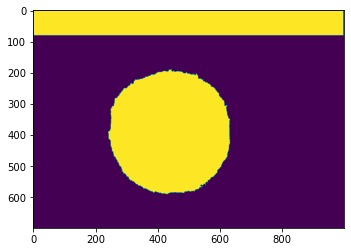

In [157]:
import matplotlib.pyplot as plt

f, ax1 = plt.subplots(1)

frame = thresh
for i, contour in enumerate(contours):
    c_area = cv2.contourArea(contour)
    c_perimeter = cv2.arcLength(contour, True)
    if (c_area > 82000 and c_area< 180000.0):
        moments_cnt = cv2.moments(contour)
        ball = contour
        cx = int(moments_cnt['m10']/moments_cnt['m00'])
        cy = int(moments_cnt['m01']/moments_cnt['m00'])
        print("area: ", c_area, "centroid: ", (cx, cy), "perimeter: ", c_perimeter)
        #ax1.plot(cx, cy, 'o')
        frame = cv2.drawContours(frame, contour, -1, (0, 255, 0), 2)

frameWithContours = cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)

#ax1.imshow(frameWithContours)
ax1.imshow(frame)

In [106]:
cv2.arcLength(ball, True)

2715.0579973459244

In [107]:
cv2.contourArea(ball)

105210.0

In [158]:
ball.shape

(697, 1, 2)

This is the ball contour. As you can see, it is a long array of x and y value pairs.

In [159]:
ball[:,0,:]

array([[443, 187],
       [440, 190],
       [438, 188],
       ...,
       [446, 189],
       [445, 188],
       [445, 187]], dtype=int32)

**Creating rows and columns from the contour.** Then, plotting them. -arrayCol instead of arrayCol so that the ball appears as if it is traveling downwards. The rows of a column start at 0 at the top most row and increase as you descend the image, opposite to the coordinates on a y-axis pointing upwards. Hence the -arrayCol.

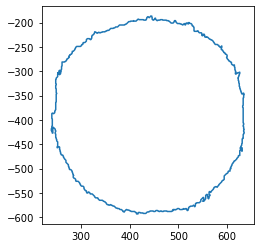

In [160]:
arrayRow = ball[:,0,0]
arrayCol = ball[:,0,1]

plt.plot(arrayRow, -arrayCol)
ax=plt.gca()
ax.set_aspect('equal')

## **Attempts at smoothing the contour**

This one is not so successful

/home/arvindn/anaconda3/envs/python39/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][570]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


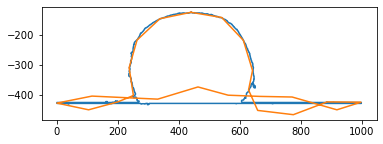

In [12]:
from scipy.interpolate import splprep, splev
x = arrayCol
y = arrayRow

smoothened = []

tck, u = splprep([x,y], u=None, s=1.0, per=1)
# https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
u_new = np.linspace(u.min(), u.max(), 25)
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splev.html
x_new, y_new = splev(u_new, tck, der=0)
# Convert it back to numpy format for opencv to be able to display it
res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
smoothened.append(np.asarray(res_array, dtype=np.int32))

cv2.drawContours(frame, smoothened, -1, (255,255,255), 2)

smoothened_arrayRow = smoothened[0][:,0,0]
smoothened_arrayCol = smoothened[0][:,0,1]
plt.plot(arrayRow, -arrayCol)
ax1 = plt.gca()
ax1.plot(smoothened_arrayCol, -smoothened_arrayRow)
ax1.set_aspect('equal')

# Arvind's comment: This smoothening does very little for our task.

**Sorting the contour:** I would like to re-order the points so that I can go from the bottom of the image below to the top of the image, i.e., from the curved part of the ball to the flat portion of the ball (the portion that is in contact with the surface on which it colliding). Hence, I call the contour "contourToBeSorted"

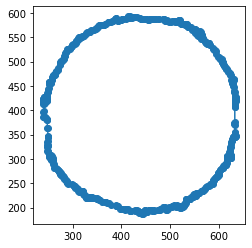

In [161]:
contourToBeSorted = ball[:,0,:]

contourToBeSorted.shape

plt.plot(contourToBeSorted[:,0], contourToBeSorted[:,1], 'o-')
ax = plt.gca()
ax.set_aspect('equal')

**Reshaping the contour array** The array contourToBeSorted looks like this: np.array([[440, 127], [440, 128], [442, 130]..]). So, this array is exactly what you'd expect if someone gave you a list of x-y coordinate pairs to define a curve.

contourT, on the other had, looks like this: [[440, 440, 442,...],[127, 128, 130,...]]. This is a slightly different representation, one in which you have a list of all x values, and a list of corresponding y values.

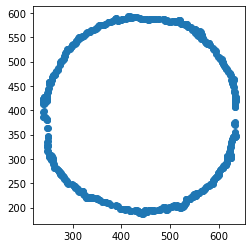

In [162]:
contourT = contourToBeSorted.T

plt.plot(contourT[0,:], contourT[1,:],'o')
ax = plt.gca()
ax.set_aspect('equal')

**Sorting contourT:** There are many ways too sort arrays in 
numpy. Not all of them are equivalent. The one that I found best was to use lexsort. In the statement below, lexsort first sorts based on contourToBeSorted.T[0,:], and then based on contourToBeSorted.T[1,:]. What is returned is a list/array of indices of contourToBeSorted that gives you the sorted contour points so that as you go along the contour points, you are monotonically increasing in x (or y) coordinates.

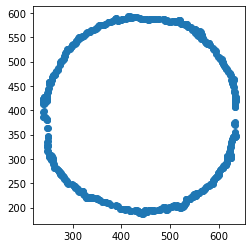

In [163]:
ind = np.lexsort((contourToBeSorted.T[0,:], 
                 contourToBeSorted.T[1,:]))

sortedContour = contourToBeSorted.T[:,ind]

plt.plot(sortedContour[0,:], sortedContour[1,:], 'o')
ax = plt.gca()
ax.set_aspect('equal')

**Centering the ball:** The average value of all the xvalues should correspond to the x value of the axis of rotation of the ball. Once I find that, I will crease a sorted and shifted contour: sortedShiftedContour

446.7446197991392


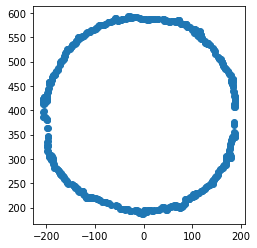

In [164]:
xmean = np.mean(sortedContour[0,:])
print(xmean)
sortedShiftedContour = sortedContour
sortedShiftedContour[0,:] = sortedShiftedContour[0,:] - xmean

plt.plot(sortedShiftedContour[0,:], 
         sortedShiftedContour[1,:], 'o')
ax = plt.gca()
ax.set_aspect('equal')

You can see how sortedShiftedContour is ordered. It looks like by the second array first and the first array next.

In [165]:
sortedShiftedContour[:,0:10]

array([[ -3,  -1,  -9,  -8,  -1,   0, -11,  -6,   5,   6],
       [187, 187, 188, 188, 188, 189, 190, 190, 191, 191]], dtype=int32)

**Folding the contours so that both appear on the positive side:**

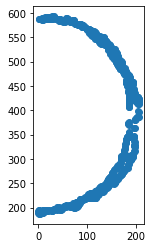

In [166]:
absSortedShiftedContour = sortedShiftedContour

absSortedShiftedContour[0,:] = np.abs(absSortedShiftedContour[0,:])

plt.plot(absSortedShiftedContour[0,:], 
         absSortedShiftedContour[1,:], 'o')
ax = plt.gca()
ax.set_aspect('equal')

**Transposed image**

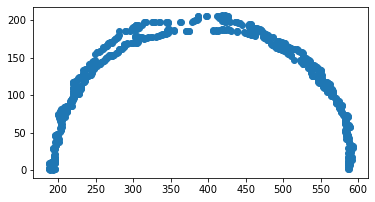

In [167]:
plt.plot(absSortedShiftedContour[1,:], 
         absSortedShiftedContour[0,:], 'o')
ax = plt.gca()
ax.set_aspect('equal')

### **Serious attempts to smoothen contours**

In [169]:
# finding unique values of one of the coordinates
u, indices = np.unique(absSortedShiftedContour[1,:],
                     return_index = True)

In [170]:
# the other coordinate, except many elements of v could corres
# -pond to the same element of u. Next, we'll take the mean 
# value of the multiple v elements corresponding to each u 
# element
v = absSortedShiftedContour[0,:]
len(v)

697

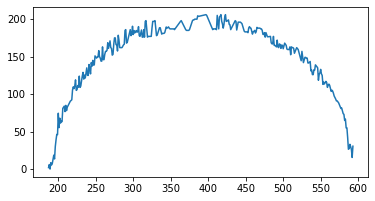

In [171]:
# This is the method for creating vunique
vunique = [np.mean(v[indices[i]:indices[i+1]]) 
           for i in np.arange(len(indices)-1)]
vunique.append(np.mean(v[indices[-1]:len(v)]))

vunique = np.array(vunique)

plt.plot(u,vunique)
ax = plt.gca()
ax.set_aspect('equal')

**Interpolation was not good for smoothening the data**

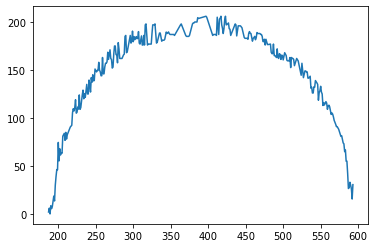

In [172]:
# Not good for smoothening data
from scipy import interpolate 

f = interpolate.interp1d(u, vunique)

plt.plot(u, f(u))

**Neither was UnivariateSpline, which is also a form of interpolation**

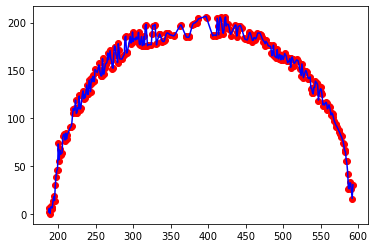

In [173]:
# Not good for smoothening data

from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(u, vunique)

plt.plot(u, vunique, 'ro')
ax = plt.gca()
#spl.set_smoothing_factor(10)
ax.plot(u, spl(u),'b')

**This worked - simply a moving window average, done efficiently using np.convolve**

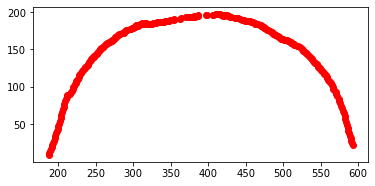

In [174]:
kernel_size = 25
kernel = np.ones(kernel_size) / kernel_size
vuniqconv = np.convolve(vunique, kernel, mode='same')

plt.plot(u, vuniqconv, 'ro')
ax = plt.gca()
ax.set_aspect('equal')

**Tried interpolation on the smoothed data. Still not good**

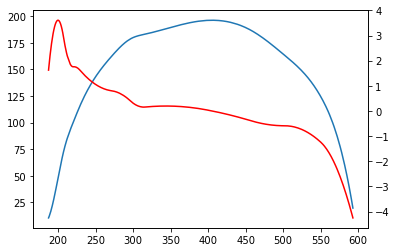

In [175]:
spl = interpolate.UnivariateSpline(u, vuniqconv)

plt.plot(u, spl(u))
ax = plt.gca()
axtwin = ax.twinx()
splderiv = spl.derivative()
axtwin.plot(u, splderiv(u), 'r')

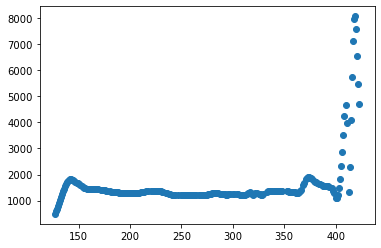

In [199]:
ubest = u[:-5]
plt.plot(ubest, 2*np.pi*spl(ubest)*np.sqrt(1+splderiv(ubest)**2), 'o')

**Finally, curve fit. Should have been the obvious solution but it will work only if you know the appropriate function for the fit** Simply using a polynomial will fail miserably. The reason is that at the lowest value of x, y rises quite rapidly. Think of a circle with center on the x-axis as it crosses the x-axis. The behavior of the curve is as $(x-x_0)^{1/2}$. Hence, the function chosen is of the form $(x-x_0)^{1/2}(a + b(x-x_0) + c(x-x_0)^2 + d(x-x_0)^3)$. Since it is not easy to find the value of $x_0$, I chose the smallest value of the column numbers, 127 as the value of $x_0$. Not the greatest strategy, but it works.

In [90]:
from scipy.optimize import curve_fit

187


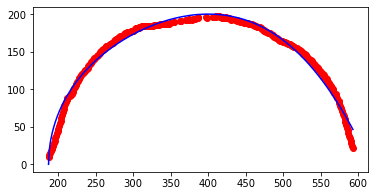

In [176]:
x0 = np.min(u)
print(x0)

def f(x, a, b, c, d):
    x0 = np.min(u)
    return (a+b*(x-x0)+c*(x-x0)**2+d*(x-x0)**3)*(x-x0)**0.5
    

popt, pcov = curve_fit(f, u, vuniqconv)



plt.plot(u, vuniqconv, 'ro')
plt.plot(u, f(u, *popt), 'b')
ax = plt.gca()
ax.set_aspect('equal')

In [177]:
# These are the values of a, b, c, d
popt

array([ 1.90877431e+01, -3.01288386e-02,  7.95508340e-05, -2.63925972e-07])

**Now that you have a smoothed curved, it should be fairly straightforward to find the area and volume of the deformed ball.**

If the $z$ axis is taken as the axis of rotation of the ball, the radius (in cylindrical coordinates) is given by $r(z)$. We have found $r(z)$ from image analysis. Now we need to find the surface area and volume of the ball.
The contribution to surface area of the region between $z$ and $z+dz$ is given by: $ 2\pi r(z) \sqrt{dr^2 + dz^2} = 2\pi r(z) \sqrt{1 + \left(\frac{dr}{dz}\right)^2} dz$. The total surface area is given by $\displaystyle \underbrace{\int_{z_{min}}^{z_{max}} 2\pi r(z) \sqrt{1 + \left(\frac{dr}{dz}\right)^2} dz}_{\text{curved part of the ball}} + \underbrace{\pi r^2(z_{max})}_{\text{flat part of ball}} $.

The total volume is given by $\displaystyle \underbrace{\int_{z_{min}}^{z_{max}} \pi r^2(z)  dz}_{\text{curved part of the ball}} $. There is no contribution to the volume from the flat part of the ball.

locSurfArea is simply the function $2\pi r(z) \sqrt{1 + \left(\frac{dr}{dz}\right)^2}$. localVolume is the function $\pi r^2(z)$. 

In [178]:
def ffdash(x, a, b, c, d):
    x0 = np.min(x)
    z=x-x0
    return 0.5*(a+b*z+c*z**2+d*z**3)**2+z*(a+b*z+c*z**2+d*z**3)*(b+2*c*z+3*d*z**2)

def surfaceArea(u, par):
    localSurfArea = 2*np.pi*(f(u, *par)**2 + ffdash(u,*par)**2)**0.5
    return localSurfArea

def ballVolume(u, par):
    localVol = np.pi*f(u, *par)**2
    return localVol

In [179]:
locSurfArea = surfaceArea(u, popt)
localVolume = ballVolume(u, popt)

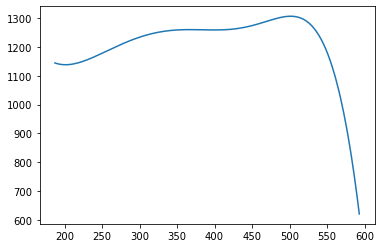

In [180]:
plt.plot(u, locSurfArea)

In [99]:
from scipy.integrate import simpson

In [183]:
surfarea = simpson(locSurfArea, u) + np.pi*vuniqconv[-1]**2

totalVol = simpson(localVolume, u)

print("surface area:", surfarea, "; total volume:", totalVol)

surface area: 492224.37373355986 ; total volume: 32908929.410937887


In [187]:
print("Average diameter of tennis ball (in pixels):", 6*totalVol/surfarea, "in pixels. \
      Valid only for undeformed ball.")

Average diameter of tennis ball (in pixels): 401.14546739716826 in pixels.       Valid only for undeformed ball.
